In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet
# import logging # No longer suppressing warnings by default in .py version

In [2]:
# --- Configuration ---
CSV_FILE_PATH = 'your_pizza_sales_data.csv'  # Make sure this file exists in the same directory
INGREDIENTS_CSV_FILE_PATH = 'ingredients.csv' # Make sure this file exists in the same directory

DATE_COLUMN = 'order_date'
TIME_COLUMN = 'order_time'
QUANTITY_COLUMN = 'quantity' # Column for quantity of pizzas sold per order
COMBINED_DATETIME_COLUMN = 'order_datetime'
PRICE_COLUMN = 'total_price'
UNIT_PRICE_COLUMN = 'unit_price'
CATEGORY_COLUMN = 'pizza_category'
NAME_COLUMN = 'pizza_name' # Column containing pizza names (e.g., 'Margherita', 'Pepperoni')
PIZZA_SIZE_COLUMN = 'pizza_size' # Column for pizza size (if available)

DATE_FORMATS_TO_TRY = [
    '%d-%m-%Y',  # For '13-01-2015'
    '%m/%d/%Y'   # For '12/1/2015'
]

In [3]:
# Removed output directory creation as outputs will be displayed inline
# PLOTS_OUTPUT_DIR = 'pizza_sales_plots'
# FORECAST_OUTPUT_DIR = 'pizza_forecast_results'
# PURCHASE_ORDER_OUTPUT_DIR = 'pizza_purchase_orders'

# Set plot style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
# plt.rcParams['font.family'] = 'Inter' # Commented out to avoid font warnings

print("Configuration Loaded. All plots and dataframes will be displayed in the console/plot window.")


Configuration Loaded. All plots and dataframes will be displayed in the console/plot window.


In [4]:
# --- Helper function to parse mixed date formats ---
def parse_date_with_multiple_formats(date_str, formats):
    for fmt in formats:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except (ValueError, TypeError):
            continue
    return pd.NaT

In [5]:
# --- Custom MAPE calculation function ---
def calculate_mape(y_true, y_pred):
    """
    Calculates Mean Absolute Percentage Error (MAPE).
    Handles cases where y_true is zero by ignoring those points
    or setting error to 100% if y_true is zero and y_pred is not.
    """
    y_true, y_pred = pd.Series(y_true).values, pd.Series(y_pred).values
    non_zero_mask = y_true != 0
    if not non_zero_mask.any():
        print("Warning: All actual values are zero. MAPE cannot be calculated meaningfully.")
        return float('inf')
    y_true_filtered = y_true[non_zero_mask]
    y_pred_filtered = y_pred[non_zero_mask]
    return mean_absolute_percentage_error(y_true_filtered, y_pred_filtered) * 100

In [8]:
# --- 0. Load Ingredient Requirements ---
pizza_ingredients_map = {}
print(f"--- Attempting to load ingredient requirements from: {INGREDIENTS_CSV_FILE_PATH} ---")
try:
    ingredients_df = pd.read_csv(INGREDIENTS_CSV_FILE_PATH)
    print("Ingredients data loaded successfully.")
    print("\nOriginal Ingredients Data Head:")
    print(ingredients_df.head()) # Use print for .py file

    # --- Data Cleaning for Ingredients Data ---
    print("\n--- Cleaning Ingredients Data ---")
    initial_rows_ingredients = len(ingredients_df)

    # 1. Handle Missing Data
    ingredients_df.dropna(subset=['pizza_name', 'pizza_ingredients', 'Items_Qty_In_Grams'], inplace=True)
    print(f"Removed {initial_rows_ingredients - len(ingredients_df)} rows with missing critical ingredient data.")
    initial_rows_ingredients = len(ingredients_df) # Update count

    # 2. Handle Inconsistent Data / Formatting
    # Standardize text columns
    for col in ['pizza_name', 'pizza_ingredients']:
        if col in ingredients_df.columns:
            ingredients_df[col] = ingredients_df[col].astype(str).str.strip().str.lower()
            print(f"Standardized '{col}' column (stripped, lowercased).")

    # Ensure 'Items_Qty_In_Grams' is numeric and handle non-positive values
    if 'Items_Qty_In_Grams' in ingredients_df.columns:
        # Convert to numeric, coercing errors to NaN
        ingredients_df['Items_Qty_In_Grams'] = pd.to_numeric(ingredients_df['Items_Qty_In_Grams'], errors='coerce')
        # Drop rows where conversion failed
        ingredients_df.dropna(subset=['Items_Qty_In_Grams'], inplace=True)
        print(f"Removed rows where 'Items_Qty_In_Grams' was non-numeric.")
        
        # Handle non-positive quantities (e.g., set to a small positive value or remove)
        # Here, we'll remove rows with zero or negative quantities as they are invalid for requirements
        ingredients_df = ingredients_df[ingredients_df['Items_Qty_In_Grams'] > 0]
        print(f"Removed rows with non-positive 'Items_Qty_In_Grams'. Current rows: {len(ingredients_df)}")
    
    # Dynamically build the pizza_ingredients_map from the cleaned CSV
    # Convert grams to KG for consistency in calculations
    for pizza_name, group in ingredients_df.groupby('pizza_name'):
        pizza_ingredients_map[pizza_name] = {}
        for _, row in group.iterrows():
            pizza_ingredients_map[pizza_name][row['pizza_ingredients']] = row['Items_Qty_In_Grams'] / 1000.0
    
    print("\nCleaned Ingredients Data Head:")
    print(ingredients_df.head()) # Use print for .py file
    print("\nDynamically created pizza_ingredients_map (first 3 entries):")
    for pizza, ingredients in list(pizza_ingredients_map.items())[:3]:
        print(f"  {pizza}: {ingredients}")
    if len(pizza_ingredients_map) > 3:
        print("  ...")

except FileNotFoundError:
    print(f"Error: '{INGREDIENTS_CSV_FILE_PATH}' not found. Creating dummy ingredient map.")
    pizza_ingredients_map = {
        'margherita': {'dough': 0.3, 'tomato sauce': 0.15, 'mozzarella': 0.2, 'basil': 0.01},
        'pepperoni': {'dough': 0.3, 'tomato sauce': 0.15, 'mozzarella': 0.2, 'pepperoni': 0.1},
        'veggie': {'dough': 0.3, 'tomato sauce': 0.15, 'mozzarella': 0.15, 'onion': 0.05, 'bell pepper': 0.05, 'mushroom': 0.05},
        'bbq chicken': {'dough': 0.3, 'bbq sauce': 0.2, 'chicken': 0.15, 'red onion': 0.05, 'cilantro': 0.01},
        'hawaiian': {'dough': 0.3, 'tomato sauce': 0.15, 'mozzarella': 0.2, 'ham': 0.1, 'pineapple': 0.1},
    }
    print("\nUsing dummy pizza_ingredients_map for demonstration.")
except KeyError as e:
    print(f"Error processing ingredients CSV: Missing expected column - {e}.")
    print("Please ensure your ingredients CSV has 'pizza_name', 'pizza_ingredients', and 'Items_Qty_In_Grams' columns.")
    raise # Re-raise the exception to stop execution

print("\n" + "="*70 + "\n")
   

--- Attempting to load ingredient requirements from: ingredients.csv ---
Ingredients data loaded successfully.

Original Ingredients Data Head:
  pizza_name_id                  pizza_name  pizza_ingredients  \
0     bbq_ckn_l  The Barbecue Chicken Pizza  Barbecued Chicken   
1     bbq_ckn_l  The Barbecue Chicken Pizza        Red Peppers   
2     bbq_ckn_l  The Barbecue Chicken Pizza      Green Peppers   
3     bbq_ckn_l  The Barbecue Chicken Pizza           Tomatoes   
4     bbq_ckn_l  The Barbecue Chicken Pizza         Red Onions   

   Items_Qty_In_Grams  
0                40.0  
1                15.0  
2                20.0  
3                30.0  
4                60.0  

--- Cleaning Ingredients Data ---
Removed 4 rows with missing critical ingredient data.
Standardized 'pizza_name' column (stripped, lowercased).
Standardized 'pizza_ingredients' column (stripped, lowercased).
Removed rows where 'Items_Qty_In_Grams' was non-numeric.
Removed rows with non-positive 'Items_Qty_In_Gra

In [9]:
# --- 1. Load Sales Data ---
print(f"--- Attempting to load sales data from: {CSV_FILE_PATH} ---")
try:
    df = pd.read_csv(CSV_FILE_PATH)
    print("Sales data loaded successfully.")
    print("\nOriginal Sales Data Head:")
    print(df.head()) # Use print for .py file

    # --- Data Cleaning for Sales Data ---
    print("\n--- Cleaning Sales Data ---")
    initial_rows_sales = len(df)

    # 1. Handle Missing Data
    # Drop rows where critical columns are missing
    df.dropna(subset=[DATE_COLUMN, TIME_COLUMN, QUANTITY_COLUMN, PRICE_COLUMN, NAME_COLUMN], inplace=True)
    print(f"Removed {initial_rows_sales - len(df)} rows with missing critical sales data.")
    initial_rows_sales = len(df) # Update count

    # 2. Handle Inconsistent Data / Formatting
    # Standardize text columns (pizza name, category, size)
    for col in [NAME_COLUMN, CATEGORY_COLUMN, PIZZA_SIZE_COLUMN]:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip().str.lower()
            print(f"Standardized '{col}' column (stripped, lowercased).\n")

    # Ensure 'total_price', 'unit_price', 'quantity' are numeric and handle non-positive values
    for col in [PRICE_COLUMN, UNIT_PRICE_COLUMN, QUANTITY_COLUMN]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df.dropna(subset=[col], inplace=True) # Drop rows where conversion failed
            print(f"Removed rows where '{col}' was non-numeric.")
            
            df = df[df[col] > 0] # Remove rows with zero or negative values
            print(f"Removed rows with non-positive '{col}'. Current rows: {len(df)}\n")

    # 3. Handle Outliers in 'total_price' (simple capping using IQR method)
    if PRICE_COLUMN in df.columns and len(df) > 1: # Ensure enough data for IQR
        Q1 = df[PRICE_COLUMN].quantile(0.25)
        Q3 = df[PRICE_COLUMN].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap outliers: values below lower_bound become lower_bound, above upper_bound become upper_bound
        outliers_before = df[(df[PRICE_COLUMN] < lower_bound) | (df[PRICE_COLUMN] > upper_bound)].shape[0]
        df[PRICE_COLUMN] = df[PRICE_COLUMN].clip(lower=lower_bound, upper=upper_bound)
        if outliers_before > 0:
            print(f"Capped {outliers_before} outliers in '{PRICE_COLUMN}' using IQR method.")
    else:
        print(f"Skipping outlier handling for '{PRICE_COLUMN}' due to insufficient data.")

    print("\nCleaned Sales Data Head:")
    print(df.head()) # Use print for .py file

except FileNotFoundError:
    print(f"Error: '{CSV_FILE_PATH}' not found. Creating dummy sales data.")
    # --- Dummy Sales Data Generation (Updated to include quantity and pizza_size) ---
    base_data = {
        'pizza_id': [i for i in range(1, 1001)],
        'order_id': [1000 + i for i in range(1000)],
    }
    
    pizza_names_for_dummy_sales = list(pizza_ingredients_map.keys())
    if not pizza_names_for_dummy_sales:
        print("Error: No pizza names found in ingredient map. Cannot generate dummy sales data.")
        raise # Re-raise the exception to stop execution

    pizza_sizes_for_dummy = ['small', 'medium', 'large'] # Dummy sizes
    
    date_range = pd.date_range(start='2023-01-01', periods=1000, freq='H')
    
    dummy_df_rows = []
    for i in range(1000):
        current_date_time = date_range[i]
        
        if i % 3 == 0:
            order_date_str = current_date_time.strftime('%m/%d/%Y')
        elif i % 5 == 0:
            order_date_str = current_date_time.strftime('%d-%m-%Y')
        else:
            order_date_str = current_date_time.strftime('%Y-%m-%d')

        pizza_name = pizza_names_for_dummy_sales[i % len(pizza_names_for_dummy_sales)]
        pizza_size = pizza_sizes_for_dummy[i % len(pizza_sizes_for_dummy)]
        
        # Base unit price and quantity
        unit_price_base = 12.00 + (i % 5) * 0.5 # Some variation
        quantity_sold = 1 + (i % 3) # 1 to 3 pizzas per order
        
        # Adjust unit price based on size
        if pizza_size == 'medium':
            unit_price_base += 2.0
        elif pizza_size == 'large':
            unit_price_base += 4.0
        
        total_price = unit_price_base * quantity_sold
        
        # Add some seasonality to total_price based on hour and day of week
        hour_of_day = current_date_time.hour
        day_of_week = current_date_time.dayofweek
        
        total_price = total_price * (1 + hour_of_day / 24 * 0.5)
        total_price = total_price * (1 + day_of_week / 7 * 0.3)
        total_price = round(total_price, 2)
        unit_price_base = round(unit_price_base, 2)

        # Introduce some missing data and inconsistencies in dummy data
        if i % 10 == 0: # Introduce a missing price
            total_price = None
        if i % 15 == 0: # Introduce a misspelled pizza name
            pizza_name = 'margerita'
        if i % 20 == 0: # Introduce a negative quantity
            quantity_sold = -1
        if i % 25 == 0: # Introduce a missing quantity
            quantity_sold = None
        
        dummy_df_rows.append({
            'pizza_id': base_data['pizza_id'][i],
            'name': pizza_name,
            'order_id': base_data['order_id'][i],
            'pizza_category': 'classic', # Simplified for dummy
            'unit_price': unit_price_base,
            'total_price': total_price,
            'quantity': quantity_sold, # Added quantity
            'pizza_size': pizza_size, # Added pizza_size
            'order_date': order_date_str,
            'order_time': current_date_time.strftime('%H:%M:%S'),
            'pizza_ingredients': 'dummy_ingredients' # Placeholder if this column exists in your sales CSV
        })
    df = pd.DataFrame(dummy_df_rows)
    print("\nUsing dummy sales data for demonstration (with simulated errors and new columns).")


--- Attempting to load sales data from: your_pizza_sales_data.csv ---
Sales data loaded successfully.

Original Sales Data Head:
   pizza_id  order_id  pizza_name_id  quantity order_date order_time  \
0         1         1     hawaiian_m         1   1/1/2015   11:38:36   
1         2         2  classic_dlx_m         1   1/1/2015   11:57:40   
2         3         2  five_cheese_l         1   1/1/2015   11:57:40   
3         4         2    ital_supr_l         1   1/1/2015   11:57:40   
4         5         2     mexicana_m         1   1/1/2015   11:57:40   

   unit_price  total_price pizza_size pizza_category  \
0       13.25        13.25          M        Classic   
1       16.00        16.00          M        Classic   
2       18.50        18.50          L         Veggie   
3       20.75        20.75          L        Supreme   
4       16.00        16.00          M         Veggie   

                                   pizza_ingredients  \
0           Sliced Ham, Pineapple, Mozzarella

In [10]:
# Combine date and time
try:
    df['parsed_date'] = df[DATE_COLUMN].apply(lambda x: parse_date_with_multiple_formats(x, DATE_FORMATS_TO_TRY))
    df['parsed_time'] = pd.to_timedelta(df[TIME_COLUMN], errors='coerce')
    df[COMBINED_DATETIME_COLUMN] = df['parsed_date'] + df['parsed_time']
    df.drop(columns=['parsed_date', 'parsed_time'], inplace=True)
    if df[COMBINED_DATETIME_COLUMN].isnull().any():
        print("\nWarning: Some date/time entries could not be parsed and resulted in NaT (Not a Time).")
        print(df[df[COMBINED_DATETIME_COLUMN].isnull()][[DATE_COLUMN, TIME_COLUMN]]) # Use print for .py file
    else:
        print(f"Successfully combined '{DATE_COLUMN}' and '{TIME_COLUMN}' into '{COMBINED_DATETIME_COLUMN}'.")
except Exception as e:
    print(f"Critical Error during date/time parsing and combination: {e}")
    raise # Re-raise the exception to stop execution


Successfully combined 'order_date' and 'order_time' into 'order_datetime'.


In [11]:
# Filter out NaT values if any occurred during parsing
df.dropna(subset=[COMBINED_DATETIME_COLUMN], inplace=True)
print("\nDataFrame Info after parsing and cleaning:")
df.info()
print("\n" + "="*70 + "\n")


DataFrame Info after parsing and cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 48606 entries, 0 to 48619
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   pizza_id           48606 non-null  int64         
 1   order_id           48606 non-null  int64         
 2   pizza_name_id      48590 non-null  object        
 3   quantity           48606 non-null  int64         
 4   order_date         48606 non-null  object        
 5   order_time         48606 non-null  object        
 6   unit_price         48606 non-null  float64       
 7   total_price        48606 non-null  float64       
 8   pizza_size         48606 non-null  object        
 9   pizza_category     48606 non-null  object        
 10  pizza_ingredients  48593 non-null  object        
 11  pizza_name         48606 non-null  object        
 12  order_datetime     48606 non-null  datetime64[ns]
dtypes: datetime64[ns](1), 

In [12]:
# --- 3. Feature Engineering: Extracting Time-Based Features ---
print("--- Extracting Time-Based Features ---")

# Day of the Week: Integer (0=Monday, 6=Sunday) and Name
df['DayOfWeek_Num'] = df[COMBINED_DATETIME_COLUMN].dt.dayofweek
df['DayOfWeek_Name'] = df[COMBINED_DATETIME_COLUMN].dt.day_name()

# Month: Integer and Name
df['Month_Num'] = df[COMBINED_DATETIME_COLUMN].dt.month
df['Month_Name'] = df[COMBINED_DATETIME_COLUMN].dt.month_name()

# Year, Quarter, Day of Month, Week of Year, Hour
df['Year'] = df[COMBINED_DATETIME_COLUMN].dt.year
df['Quarter'] = df[COMBINED_DATETIME_COLUMN].dt.quarter
df['DayOfMonth'] = df[COMBINED_DATETIME_COLUMN].dt.day
df['WeekOfYear'] = df[COMBINED_DATETIME_COLUMN].dt.isocalendar().week.astype(int)
df['Hour'] = df[COMBINED_DATETIME_COLUMN].dt.hour # Now always extracted as time component is combined

# Is Weekend?
df['IsWeekend'] = df['DayOfWeek_Num'].isin([5, 6]) # True if Saturday (5) or Sunday (6)

print("\nFirst 5 rows with new features:")
print(df.head()) # Use print for .py file
print("\n" + "="*70 + "\n")


--- Extracting Time-Based Features ---

First 5 rows with new features:
   pizza_id  order_id  pizza_name_id  quantity order_date order_time  \
0         1         1     hawaiian_m         1   1/1/2015   11:38:36   
1         2         2  classic_dlx_m         1   1/1/2015   11:57:40   
2         3         2  five_cheese_l         1   1/1/2015   11:57:40   
3         4         2    ital_supr_l         1   1/1/2015   11:57:40   
4         5         2     mexicana_m         1   1/1/2015   11:57:40   

   unit_price  total_price pizza_size pizza_category  ... DayOfWeek_Num  \
0       13.25        13.25          m        classic  ...             3   
1       16.00        16.00          m        classic  ...             3   
2       18.50        18.50          l         veggie  ...             3   
3       20.75        20.75          l        supreme  ...             3   
4       16.00        16.00          m         veggie  ...             3   

  DayOfWeek_Name Month_Num  Month_Name  Year

--- Seasonality Analysis ---


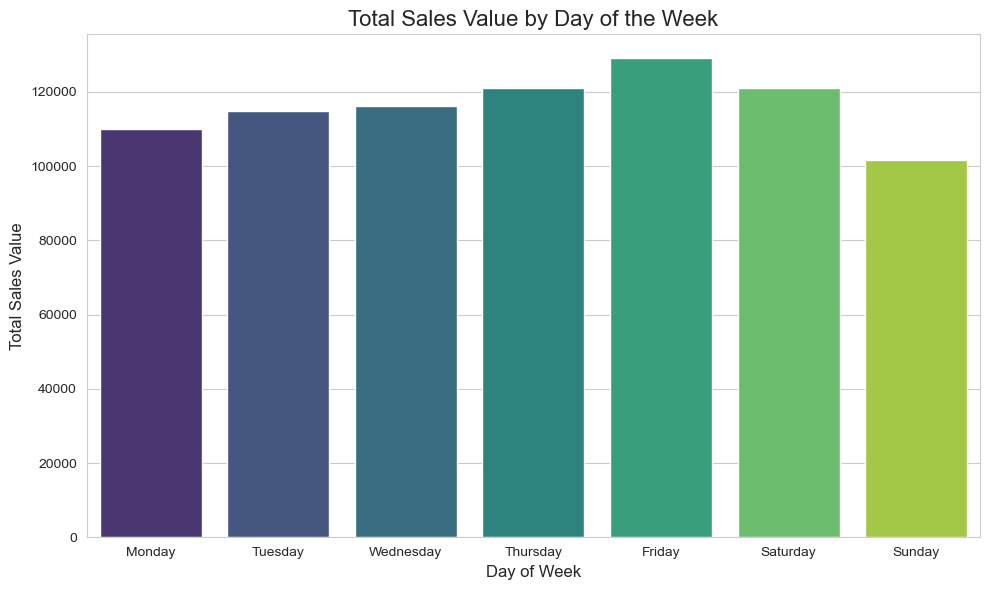

In [13]:
# --- 5. Seasonality Analysis (Plots displayed inline) ---
print("--- Seasonality Analysis ---")

# Sales by Day of the Week (using total_price)
sales_by_day = df.groupby('DayOfWeek_Name')[PRICE_COLUMN].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_day.index, y=sales_by_day.values, palette='viridis')
plt.title('Total Sales Value by Day of the Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Total Sales Value', fontsize=12)
plt.tight_layout()
plt.show()
plt.close()

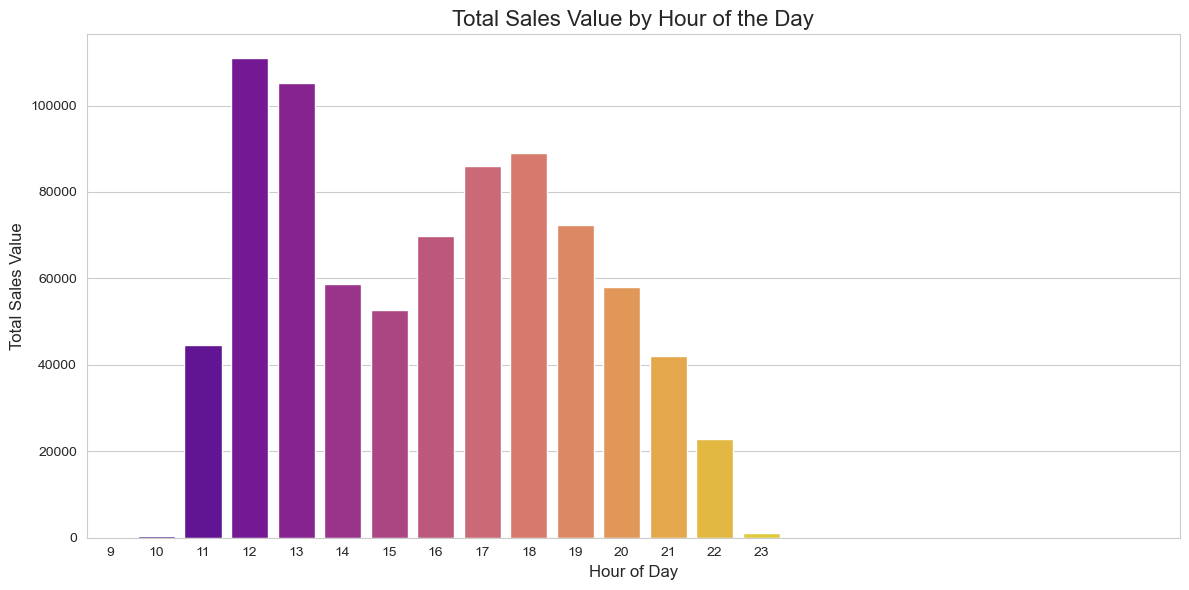

In [14]:
# Sales by Hour of the Day (using total_price)
sales_by_hour = df.groupby('Hour')[PRICE_COLUMN].sum().sort_index()
plt.figure(figsize=(12, 6))
sns.barplot(x=sales_by_hour.index, y=sales_by_hour.values, palette='plasma')
plt.title('Total Sales Value by Hour of the Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Total Sales Value', fontsize=12)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()
plt.close()

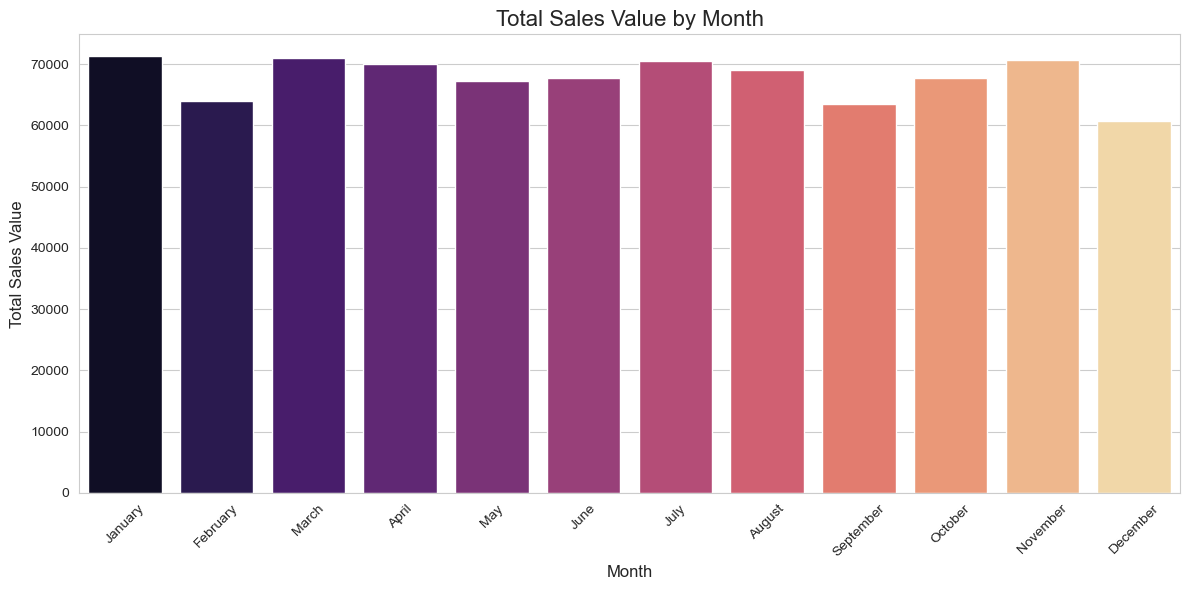

In [15]:
# Sales by Month (using total_price)
sales_by_month = df.groupby('Month_Name')[PRICE_COLUMN].sum().reindex(
    ['January', 'February', 'March', 'April', 'May', 'June',
     'July', 'August', 'September', 'October', 'November', 'December']
)
plt.figure(figsize=(12, 6))
sns.barplot(x=sales_by_month.index, y=sales_by_month.values, palette='magma')
plt.title('Total Sales Value by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales Value', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.close()

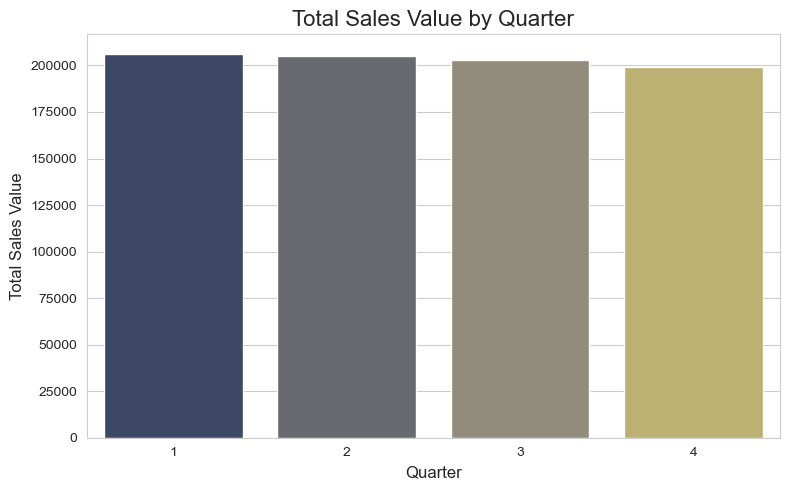

In [16]:
# Sales by Quarter (using total_price)
sales_by_quarter = df.groupby('Quarter')[PRICE_COLUMN].sum()
plt.figure(figsize=(8, 5))
sns.barplot(x=sales_by_quarter.index, y=sales_by_quarter.values, palette='cividis')
plt.title('Total Sales Value by Quarter', fontsize=16)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Total Sales Value', fontsize=12)
plt.tight_layout()
plt.show()
plt.close()

print("\n" + "="*70 + "\n")

--- Pattern Identification: Sales by Pizza Category and Name ---


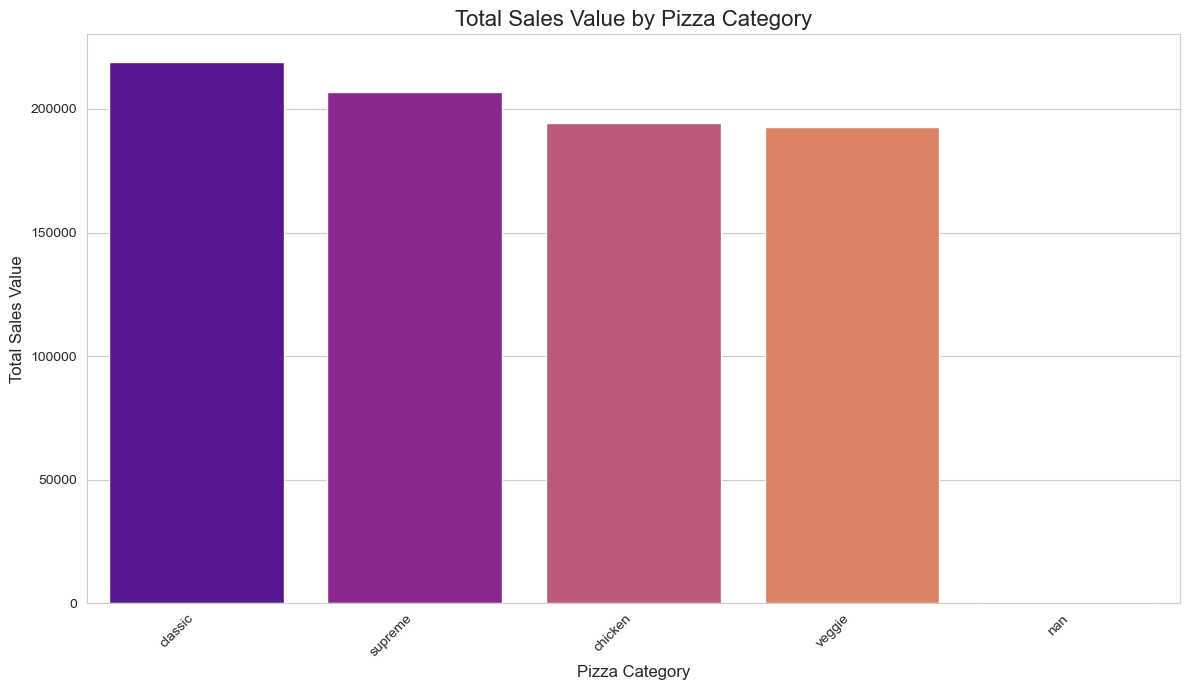

In [17]:
# --- 6. Pattern Identification: Sales by Pizza Category and Name (Plots displayed inline) ---
print("--- Pattern Identification: Sales by Pizza Category and Name ---")

# Sales by Pizza Category (using total_price)
sales_by_category = df.groupby(CATEGORY_COLUMN)[PRICE_COLUMN].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 7))
sns.barplot(x=sales_by_category.index, y=sales_by_category.values, palette='plasma')
plt.title('Total Sales Value by Pizza Category', fontsize=16)
plt.xlabel('Pizza Category', fontsize=12)
plt.ylabel('Total Sales Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.close()

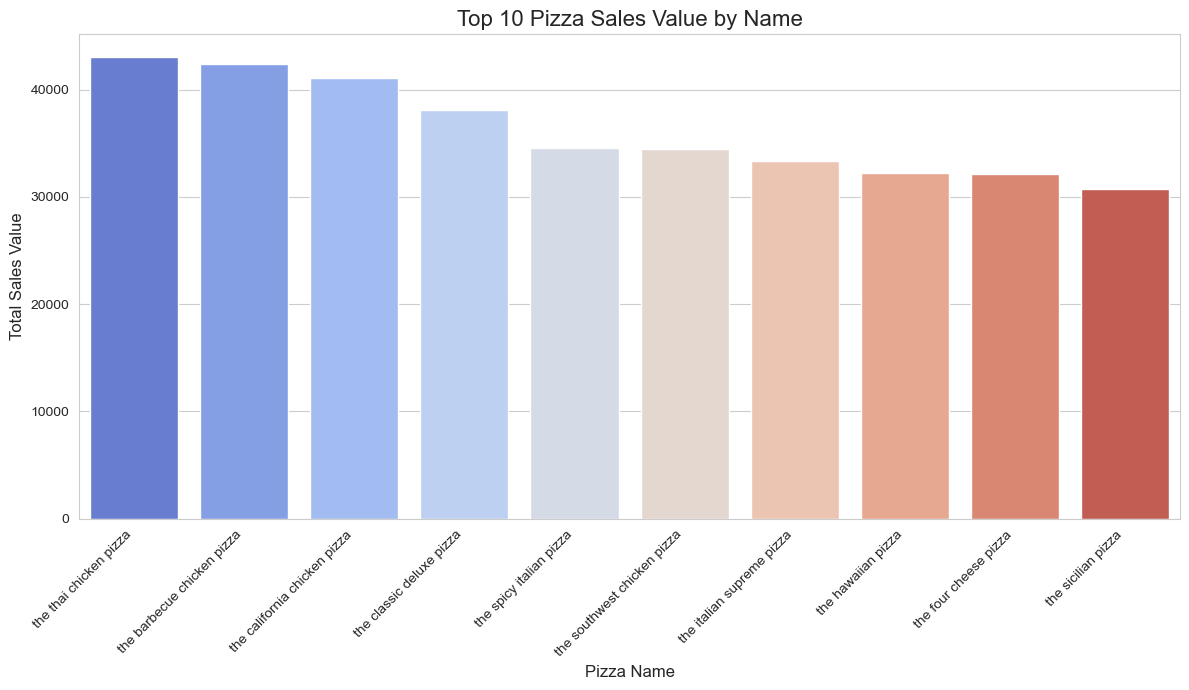

In [18]:
# Top 10 Sales by Pizza Name (using total_price)
sales_by_name = df.groupby(NAME_COLUMN)[PRICE_COLUMN].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 7))
sns.barplot(x=sales_by_name.index, y=sales_by_name.values, palette='coolwarm')
plt.title('Top 10 Pizza Sales Value by Name', fontsize=16)
plt.xlabel('Pizza Name', fontsize=12)
plt.ylabel('Total Sales Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.close()

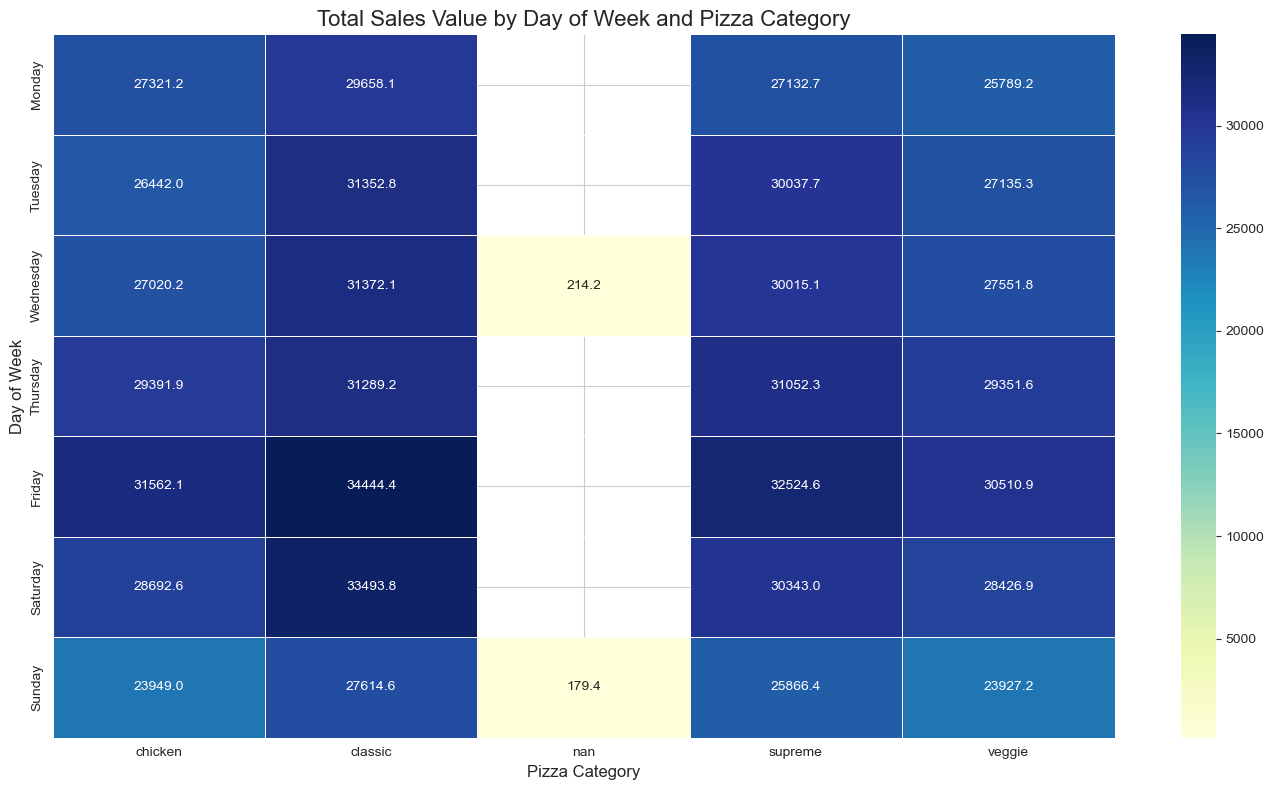

In [19]:
# Sales by Day of Week and Pizza Category (Heatmap, using total_price)
sales_category_day = df.groupby(['DayOfWeek_Name', CATEGORY_COLUMN])[PRICE_COLUMN].sum().unstack()
sales_category_day = sales_category_day.reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
) # Ensure consistent order of days

plt.figure(figsize=(14, 8))
sns.heatmap(sales_category_day, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title('Total Sales Value by Day of Week and Pizza Category', fontsize=16)
plt.xlabel('Pizza Category', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.tight_layout()
plt.show()
plt.close()

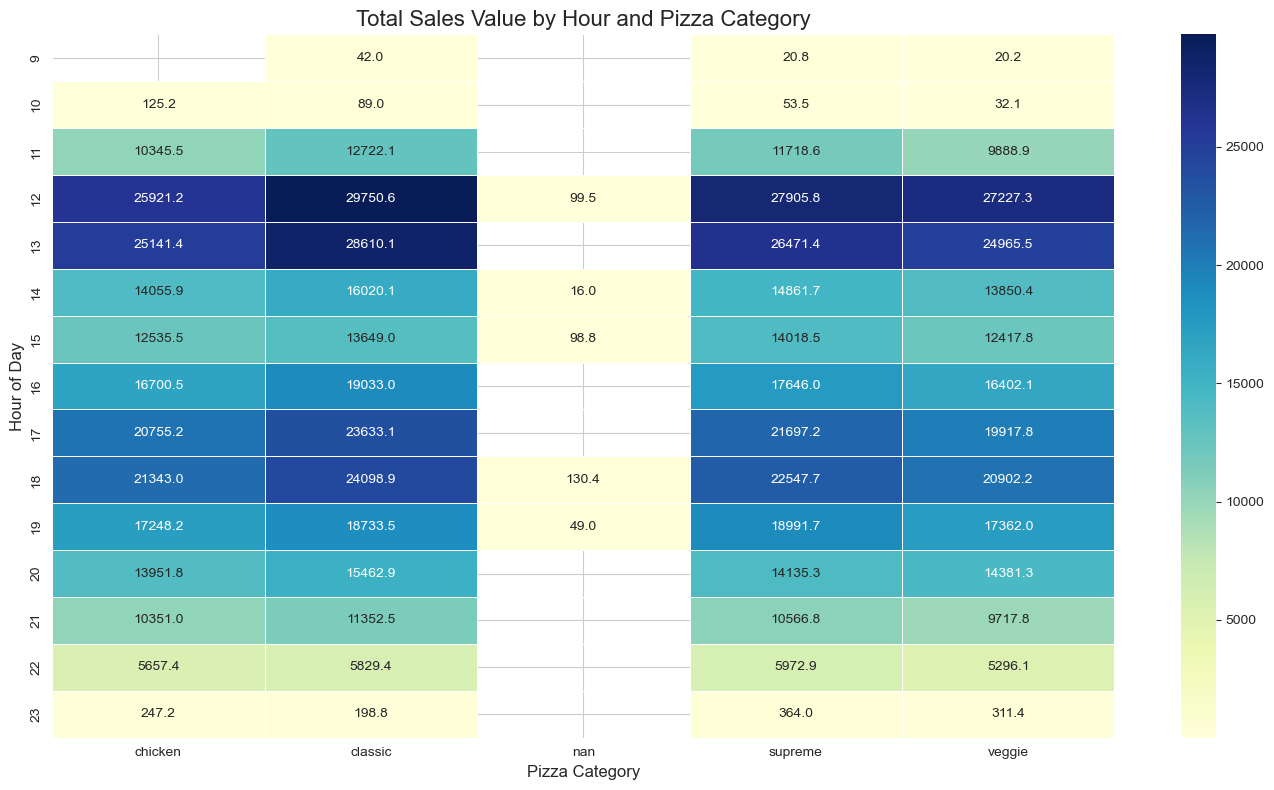

In [20]:
# Sales by Hour and Pizza Category (Heatmap, using total_price)
sales_category_hour = df.groupby(['Hour', CATEGORY_COLUMN])[PRICE_COLUMN].sum().unstack()
plt.figure(figsize=(14, 8))
sns.heatmap(sales_category_hour, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title('Total Sales Value by Hour and Pizza Category', fontsize=16)
plt.xlabel('Pizza Category', fontsize=12)
plt.ylabel('Hour of Day', fontsize=12)
plt.tight_layout()
plt.show()
plt.close()

print("\n" + "="*70 + "\n")

In [21]:
# --- 7. Time Series Forecasting (Now forecasting QUANTITY) ---
print("--- Time Series Forecasting (Forecasting Quantity) ---")

# Aggregate data to daily total QUANTITY sold for forecasting
# This is a key change: 'y' for Prophet is now total quantity, not total price.
daily_quantity_for_forecast = df.set_index(COMBINED_DATETIME_COLUMN)[QUANTITY_COLUMN].resample('D').sum().reset_index()
daily_quantity_for_forecast.columns = ['ds', 'y'] # Prophet requires 'ds' and 'y' columns

print("\nDaily Quantity for Forecasting (first 5 rows):")
print(daily_quantity_for_forecast.head()) # Use print for .py file
print(f"Total days of data: {len(daily_quantity_for_forecast)}")

TEST_DAYS = 30
if len(daily_quantity_for_forecast) < TEST_DAYS + 7:
    print(f"Warning: Not enough data for a {TEST_DAYS}-day test set. Using a smaller test set.")
    if len(daily_quantity_for_forecast) > 7:
        TEST_DAYS = max(7, len(daily_quantity_for_forecast) // 5)
    else:
        print("Error: Insufficient data for time series forecasting. Need at least some historical data.")
        raise # Re-raise the exception to stop execution

train_data = daily_quantity_for_forecast[:-TEST_DAYS]
test_data = daily_quantity_for_forecast[-TEST_DAYS:]

print(f"\nTraining data covers from {train_data['ds'].min().date()} to {train_data['ds'].max().date()}")
print(f"Test data covers from {test_data['ds'].min().date()} to {test_data['ds'].max().date()}")
print(f"Number of training data points: {len(train_data)}")
print(f"Number of test data points: {len(test_data)}")

--- Time Series Forecasting (Forecasting Quantity) ---

Daily Quantity for Forecasting (first 5 rows):
          ds    y
0 2015-01-01  162
1 2015-01-02  191
2 2015-01-03   99
3 2015-01-04  135
4 2015-01-05  154
Total days of data: 365

Training data covers from 2015-01-01 to 2015-12-01
Test data covers from 2015-12-02 to 2015-12-31
Number of training data points: 335
Number of test data points: 30



--- Training Facebook Prophet Model (on Quantity) ---


16:23:45 - cmdstanpy - INFO - Chain [1] start processing
16:23:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model (Quantity) MAPE: 15.72%



C:\Users\DC\AppData\Local\Temp\ipykernel_10996\3096237516.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


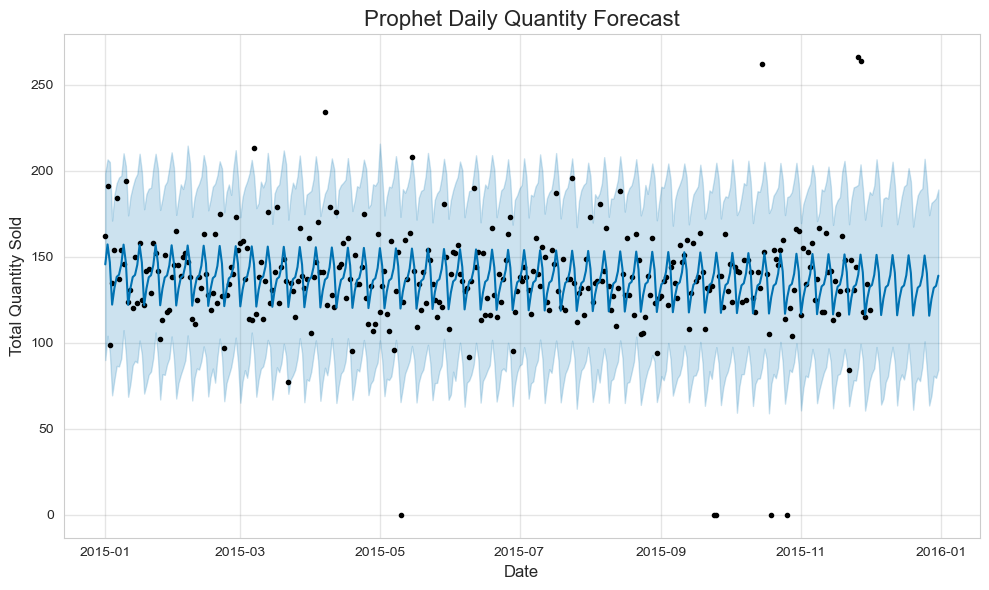

C:\Users\DC\AppData\Local\Temp\ipykernel_10996\3096237516.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.98])


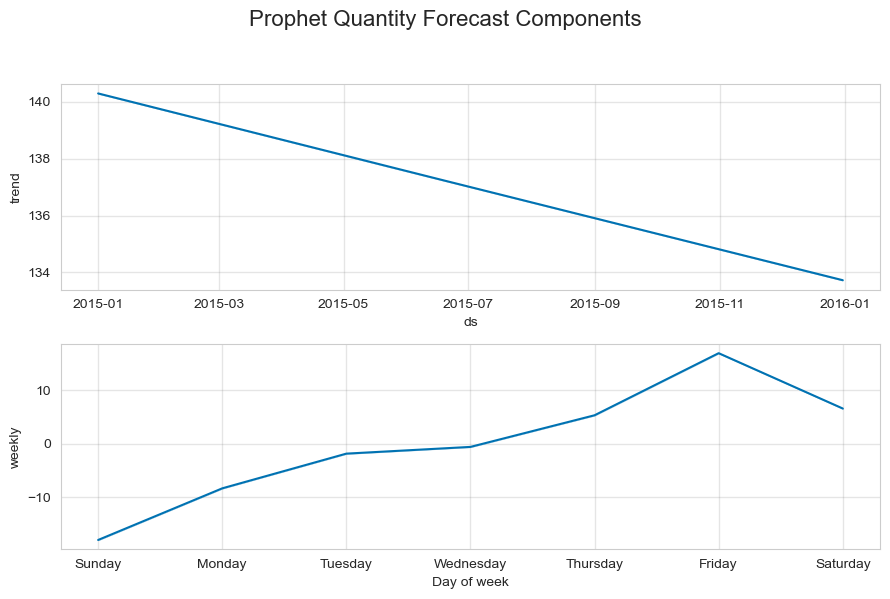

In [22]:
# --- Model 1: Facebook Prophet ---
print("\n--- Training Facebook Prophet Model (on Quantity) ---")
prophet_model = Prophet(
    yearly_seasonality=True if len(daily_quantity_for_forecast) > 365 else False,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive',
    interval_width=0.95
)

prophet_model.fit(train_data)

future_prophet = prophet_model.make_future_dataframe(periods=TEST_DAYS, freq='D')
forecast_prophet = prophet_model.predict(future_prophet)
prophet_predictions = forecast_prophet[['ds', 'yhat']].set_index('ds').loc[test_data['ds']].reset_index()
prophet_predictions.rename(columns={'yhat': 'Prophet_Forecast_Quantity'}, inplace=True)

mape_prophet = calculate_mape(test_data['y'], prophet_predictions['Prophet_Forecast_Quantity'])
print(f"Prophet Model (Quantity) MAPE: {mape_prophet:.2f}%\n")

fig_prophet = prophet_model.plot(forecast_prophet)
plt.title('Prophet Daily Quantity Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Quantity Sold', fontsize=12)
plt.tight_layout()
plt.show()
plt.close()

fig_comp_prophet = prophet_model.plot_components(forecast_prophet)
plt.suptitle('Prophet Quantity Forecast Components', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()
plt.close()



--- Training Seasonal Naive (Weekly) Model (on Quantity) ---
Seasonal Naive Model (Quantity) MAPE: 28.99%


--- Comparing Model Performance (for Quantity) ---
Prophet Model (Quantity) MAPE: 15.72%
Seasonal Naive Model (Quantity) MAPE: 28.99%


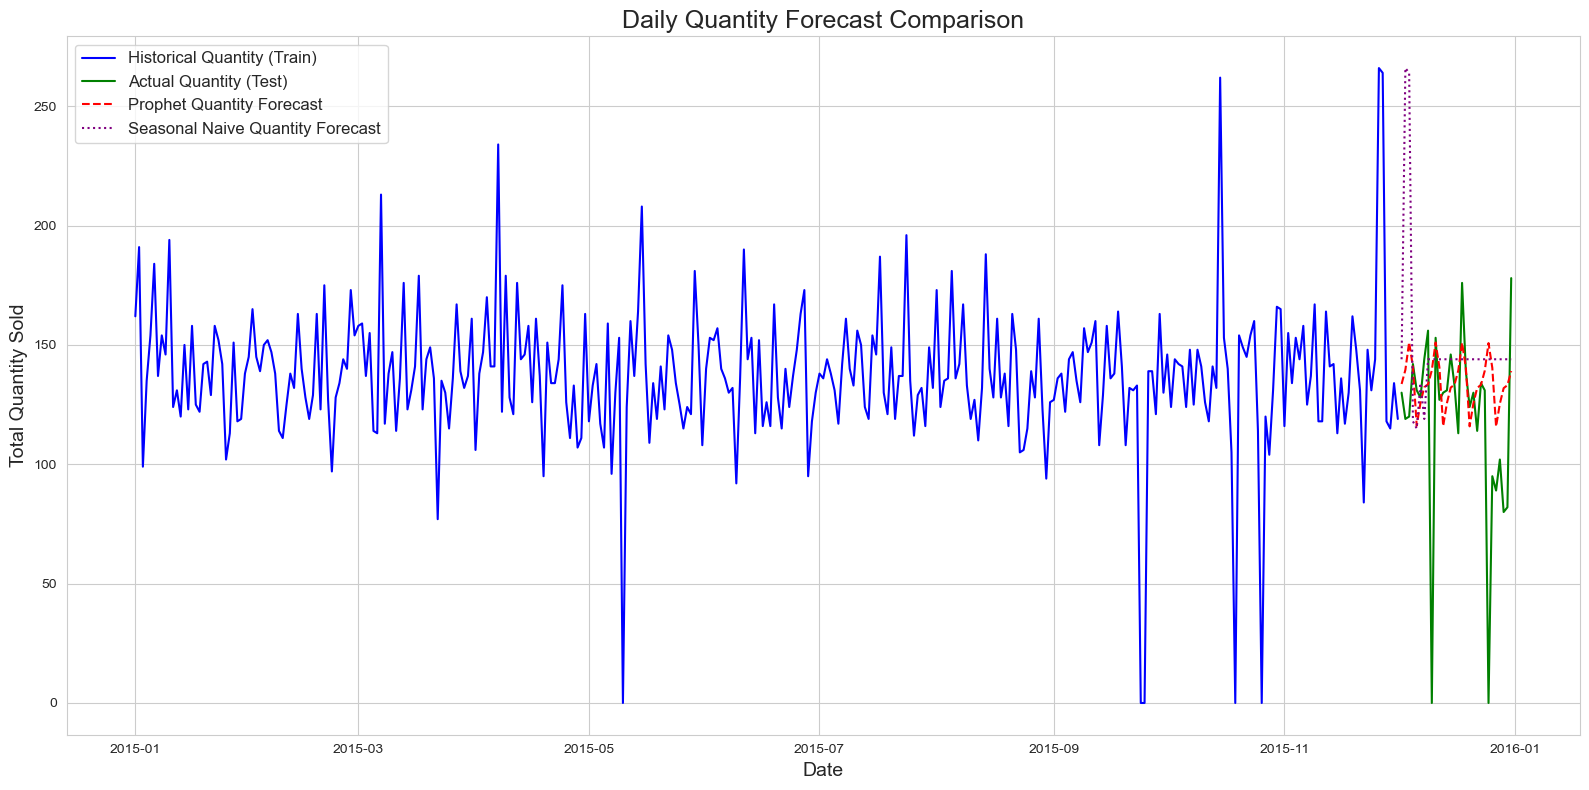

In [23]:
# --- Model 2: Seasonal Naive Baseline (on Quantity) ---
print("\n--- Training Seasonal Naive (Weekly) Model (on Quantity) ---")
seasonal_period = 7

if len(train_data) < seasonal_period:
    print(f"Warning: Not enough training data ({len(train_data)} points) for Seasonal Naive with period {seasonal_period}. Skipping.")
    mape_seasonal_naive = float('nan')
else:
    seasonal_naive_predictions = []
    for i in range(TEST_DAYS):
        current_test_date_idx = len(train_data) + i
        past_seasonal_idx = current_test_date_idx - seasonal_period
        
        if past_seasonal_idx >= 0 and past_seasonal_idx < len(train_data):
            seasonal_naive_predictions.append(train_data.iloc[past_seasonal_idx]['y'])
        else:
            seasonal_naive_predictions.append(train_data.iloc[-seasonal_period]['y']) # Fallback if past_seasonal_idx is out of bounds
            
    if len(seasonal_naive_predictions) < len(test_data):
        last_val = seasonal_naive_predictions[-1] if seasonal_naive_predictions else train_data['y'].iloc[-1]
        seasonal_naive_predictions.extend([last_val] * (len(test_data) - len(seasonal_naive_predictions)))

    seasonal_naive_df = pd.DataFrame({
        'ds': test_data['ds'],
        'Seasonal_Naive_Forecast_Quantity': seasonal_naive_predictions[:len(test_data)]
    })

    mape_seasonal_naive = calculate_mape(test_data['y'], seasonal_naive_df['Seasonal_Naive_Forecast_Quantity'])
    print(f"Seasonal Naive Model (Quantity) MAPE: {mape_seasonal_naive:.2f}%\n")


# --- Compare Models and Visualize Forecasts (for Quantity) ---
print("\n--- Comparing Model Performance (for Quantity) ---")
print(f"Prophet Model (Quantity) MAPE: {mape_prophet:.2f}%")
if not pd.isna(mape_seasonal_naive):
    print(f"Seasonal Naive Model (Quantity) MAPE: {mape_seasonal_naive:.2f}%")
else:
    print("Seasonal Naive Model (Quantity) MAPE: Not calculated (insufficient data)")


plt.figure(figsize=(16, 8))
plt.plot(train_data['ds'], train_data['y'], label='Historical Quantity (Train)', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Actual Quantity (Test)', color='green')
plt.plot(prophet_predictions['ds'], prophet_predictions['Prophet_Forecast_Quantity'], label='Prophet Quantity Forecast', color='red', linestyle='--')

if not pd.isna(mape_seasonal_naive):
    plt.plot(seasonal_naive_df['ds'], seasonal_naive_df['Seasonal_Naive_Forecast_Quantity'], label='Seasonal Naive Quantity Forecast', color='purple', linestyle=':')

plt.title('Daily Quantity Forecast Comparison', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Quantity Sold', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

print("\n" + "="*70 + "\n")

16:24:42 - cmdstanpy - INFO - Chain [1] start processing


--- Sales Forecasting for the Next Week (Forecasting Quantity) ---


16:24:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\DC\AppData\Local\Temp\ipykernel_10996\1371328438.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()



Pizza Quantity Forecast for the Next 7 Days:
          ds  yhat  yhat_lower  yhat_upper
0 2016-01-01   145          89         201
1 2016-01-02   136          77         194
2 2016-01-03   113          56         169
3 2016-01-04   122          65         178
4 2016-01-05   128          71         183
5 2016-01-06   129          72         188
6 2016-01-07   133          76         186


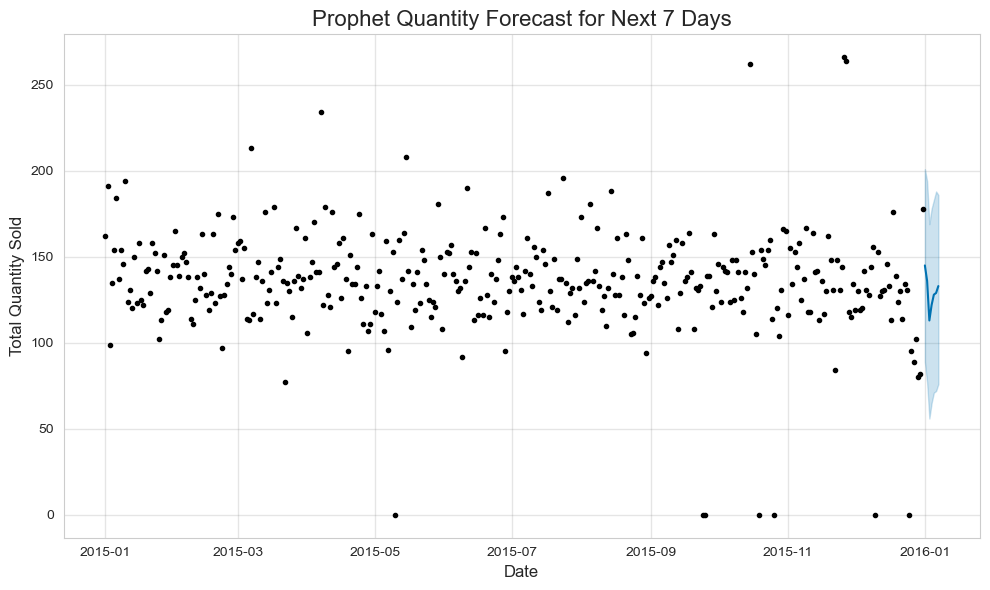



--- Calculating Ingredient Requirements for Forecasted Sales ---


Historical Pizza Sales Proportions (by quantity sold):

                                            total_quantity_sold
pizza_name                                                     
the barbecue chicken pizza                             0.049052
the big meat pizza                                     0.038600
the brie carre pizza                                   0.009887
the calabrese pizza                                    0.018906
the california chicken pizza                           0.047821
the chicken alfredo pizza                              0.019915
the chicken pesto pizza                                0.019633
the classic deluxe pizza                               0.049496
the five cheese pizza                                  0.028410
the four cheese pizza                                  0.038358
the greek pizza                                        0.028652
the green garden pizza                     

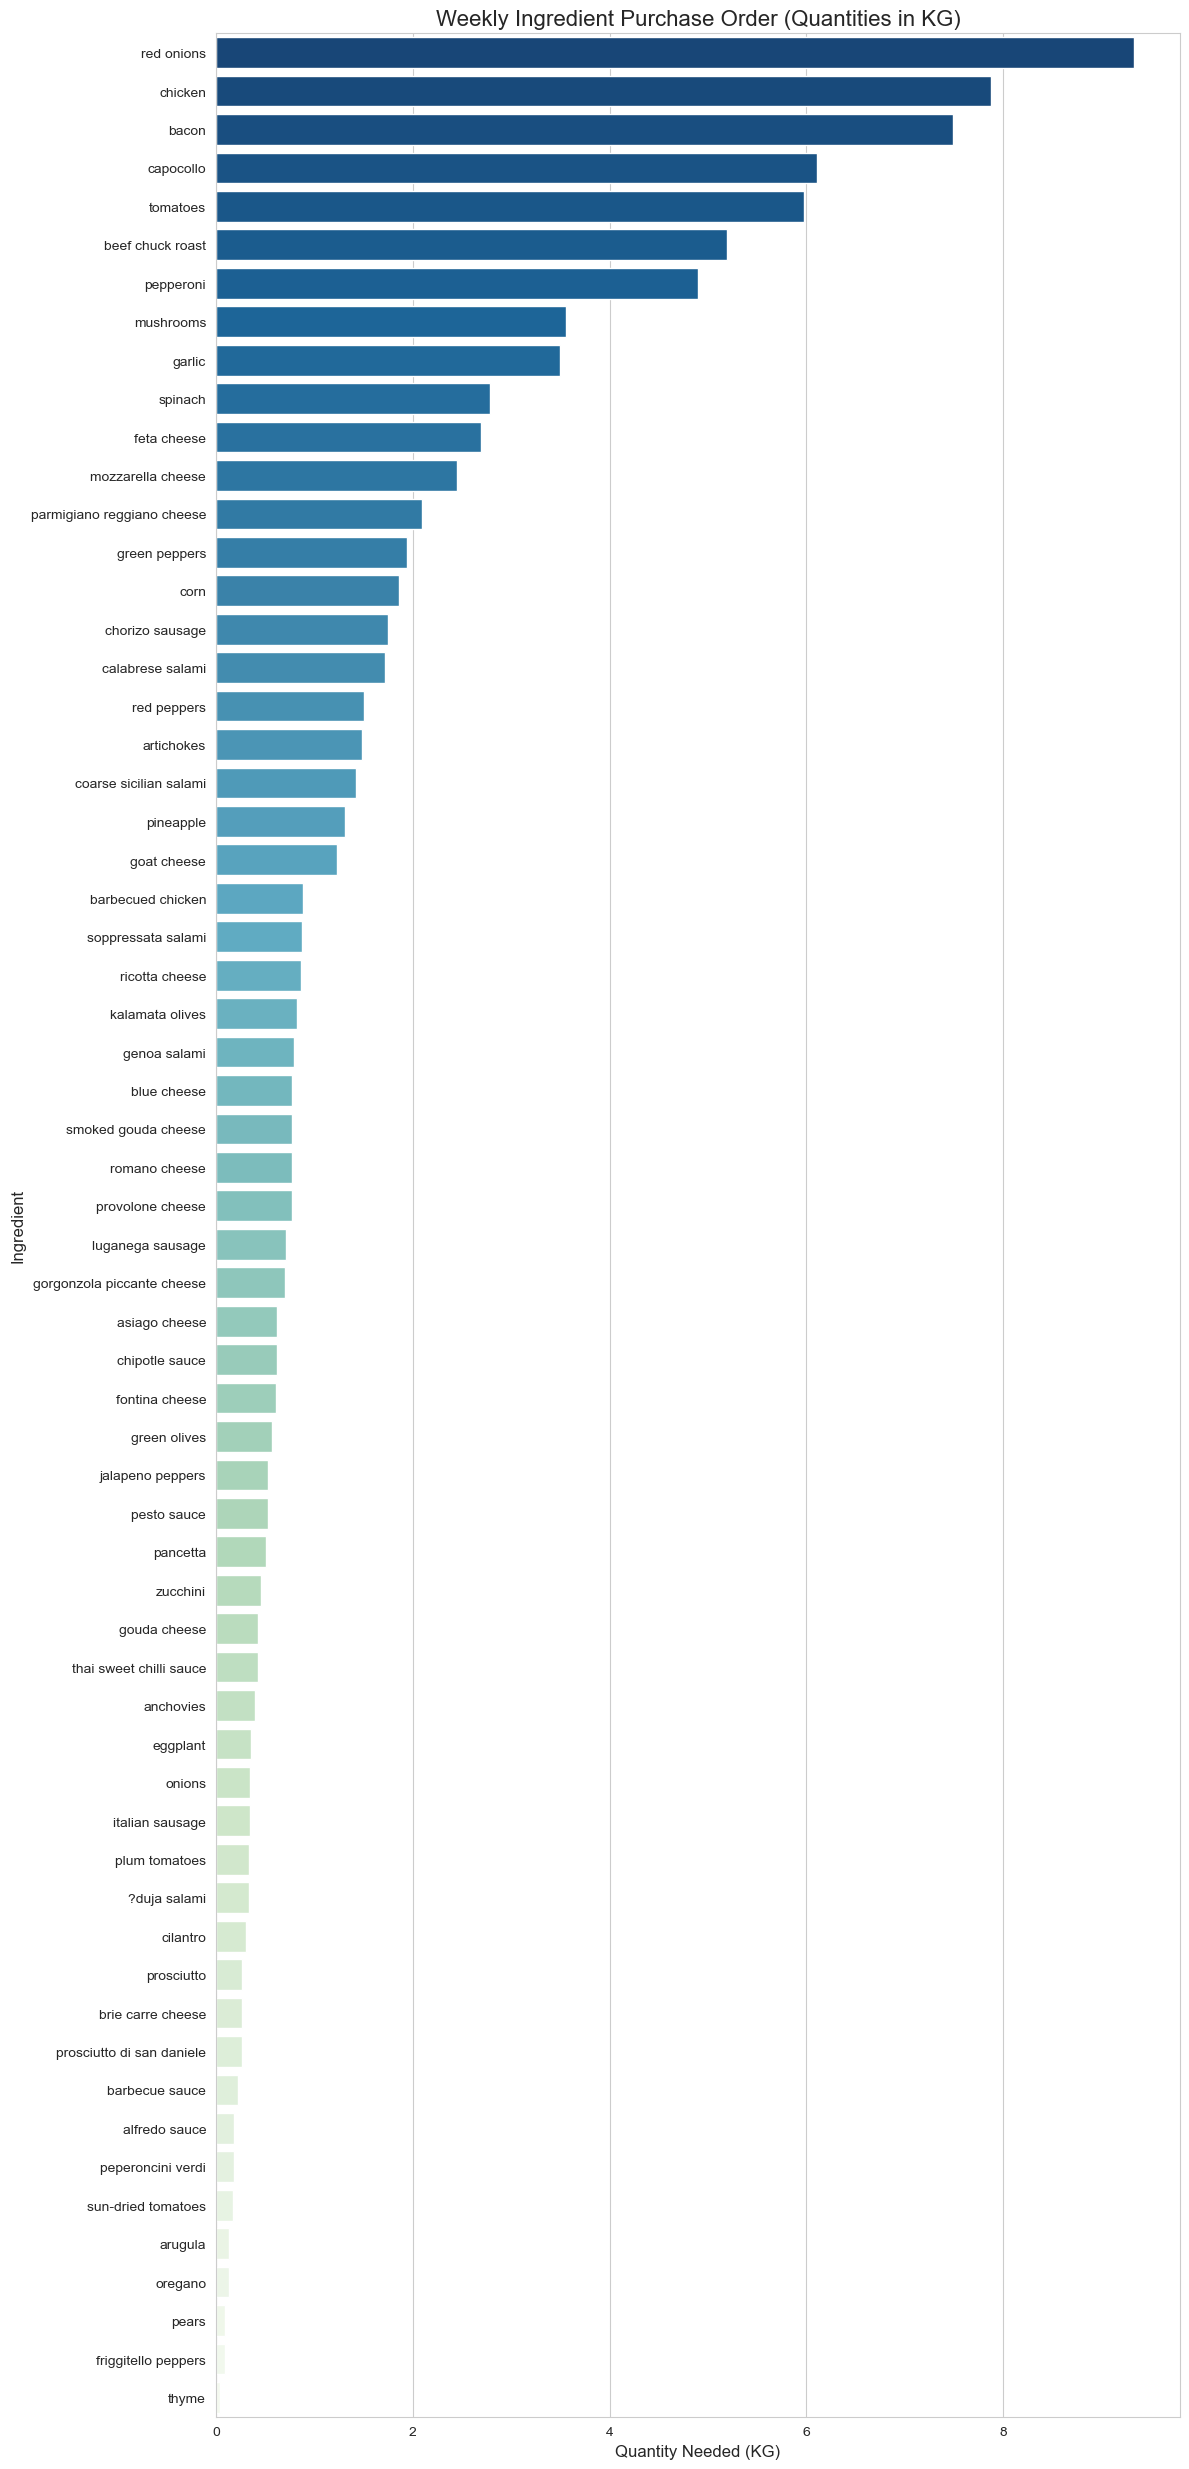



--- Analysis, Forecasting, and Ingredient Planning Complete ---
All plots and dataframes are displayed directly in the console/plot window.


In [24]:
# --- 8. Sales Forecasting for the Next Week (Now forecasting QUANTITY) ---
print("--- Sales Forecasting for the Next Week (Forecasting Quantity) ---")
FORECAST_PERIOD_DAYS = 7 # Forecast for the next 7 days

# Train Prophet model on ALL available historical quantity data for the final forecast
final_prophet_model = Prophet(
    yearly_seasonality=True if len(daily_quantity_for_forecast) > 365 else False,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive',
    interval_width=0.95
)
final_prophet_model.fit(daily_quantity_for_forecast) # Fit on all quantity data

# Create future DataFrame for the next 7 days
future_forecast_period = final_prophet_model.make_future_dataframe(periods=FORECAST_PERIOD_DAYS, freq='D', include_history=False)
forecast_next_week = final_prophet_model.predict(future_forecast_period)

# Ensure forecasted quantities are non-negative integers (as quantities can't be negative or fractional)
forecast_next_week['yhat'] = forecast_next_week['yhat'].apply(lambda x: max(0, round(x)))
forecast_next_week['yhat_lower'] = forecast_next_week['yhat_lower'].apply(lambda x: max(0, round(x)))
forecast_next_week['yhat_upper'] = forecast_next_week['yhat_upper'].apply(lambda x: max(0, round(x)))


print(f"\nPizza Quantity Forecast for the Next {FORECAST_PERIOD_DAYS} Days:")
print(forecast_next_week[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]) # Use print for .py file


# Plot the final forecast (history + next week)
fig_final_forecast = final_prophet_model.plot(forecast_next_week)
plt.title(f'Prophet Quantity Forecast for Next {FORECAST_PERIOD_DAYS} Days', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Quantity Sold', fontsize=12)
plt.tight_layout()
plt.show()
plt.close()

print("\n" + "="*70 + "\n")

# --- 9. Ingredient Requirements and Purchase Order ---
print("--- Calculating Ingredient Requirements for Forecasted Sales ---\n")

# Calculate historical proportion of each pizza type in terms of total sales quantity
# This assumes that the proportion of pizzas sold by count is reflected in total sales quantity
# and that this proportion will hold for the forecast period.
# IMPORTANT: Now using 'quantity' column for proportions
pizza_counts = df.groupby(NAME_COLUMN)[QUANTITY_COLUMN].sum().reset_index(name='total_quantity_sold')
total_pizza_count_overall = pizza_counts['total_quantity_sold'].sum()

# Handle case where total_pizza_count_overall might be zero after cleaning
if total_pizza_count_overall == 0:
    print("Warning: No valid pizza quantities found after cleaning. Cannot calculate pizza proportions or ingredient needs.")
    pizza_proportions = pd.Series() # Empty series
else:
    pizza_proportions = pizza_counts.set_index(NAME_COLUMN)['total_quantity_sold'] / total_pizza_count_overall

print("\nHistorical Pizza Sales Proportions (by quantity sold):\n")
print(pizza_proportions.to_frame()) # Use print for .py file


# Initialize a dictionary to store total ingredient needs
total_ingredient_needs = {}

# Iterate through the forecasted daily QUANTITY sales for the next week
for index, row in forecast_next_week.iterrows():
    forecast_date = row['ds']
    # yhat is total quantity forecasted
    forecasted_total_pizza_units = row['yhat'] # This is now the forecasted quantity of pizzas
    
    # Distribute the total forecasted quantity among pizza types based on historical proportions
    for pizza_name, proportion in pizza_proportions.items():
        # Ensure pizza_name is lowercased to match the cleaned ingredient map keys
        pizza_name_cleaned = pizza_name.lower()
        if pizza_name_cleaned in pizza_ingredients_map:
            # Estimated number of units of this specific pizza type to be sold on this day
            estimated_pizza_units_of_type = forecasted_total_pizza_units * proportion
            
            # Add ingredient requirements for this pizza type to total needs
            for ingredient, quantity_per_pizza in pizza_ingredients_map[pizza_name_cleaned].items():
                needed_quantity = estimated_pizza_units_of_type * quantity_per_pizza
                total_ingredient_needs[ingredient] = total_ingredient_needs.get(ingredient, 0) + needed_quantity
        else:
            print(f"Warning: Pizza '{pizza_name}' (cleaned to '{pizza_name_cleaned}') found in sales data but not in 'pizza_ingredients_map'. Skipping ingredient calculation for this pizza.")

print("\n--- Comprehensive Purchase Order for Next Week ---\n")
if total_ingredient_needs: # Only create DataFrame if there are ingredients to order
    purchase_order_df = pd.DataFrame(total_ingredient_needs.items(), columns=['Ingredient', 'Quantity Needed (KG)'])
    purchase_order_df['Quantity Needed (KG)'] = purchase_order_df['Quantity Needed (KG)'].round(2) # Round for readability
    purchase_order_df = purchase_order_df.sort_values(by='Quantity Needed (KG)', ascending=False).reset_index(drop=True)

    print(purchase_order_df) # Use print for .py file

    # Plot the Purchase Order
    plt.figure(figsize=(12, max(6, len(purchase_order_df) * 0.4))) # Adjust height based on number of ingredients
    sns.barplot(x='Quantity Needed (KG)', y='Ingredient', data=purchase_order_df, palette='GnBu_r')
    plt.title('Weekly Ingredient Purchase Order (Quantities in KG)', fontsize=16)
    plt.xlabel('Quantity Needed (KG)', fontsize=12)
    plt.ylabel('Ingredient', fontsize=12)
    plt.tight_layout()
    plt.show()
    plt.close()

else:
    print("No ingredient needs calculated. This might be due to no sales data, no ingredient map, or all forecasted sales being zero.")

print("\n" + "="*70 + "\n")

print("--- Analysis, Forecasting, and Ingredient Planning Complete ---")
print("All plots and dataframes are displayed directly in the console/plot window.")